In [4]:
import sys
print(sys.version)

path = "C:\\Users\\chris\\Documents\\NEON\\"
import os
os.chdir(path)
print(os.getcwd())

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
C:\Users\chris\Documents\NEON


In [6]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [7]:
def RGBraster2array(RGB_geotif):
    metadata = {}
    dataset = gdal.Open(RGB_geotif)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    for i in range(1, dataset.RasterCount+1):
        band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        band[band==metadata['noDataValue']]=np.nan
        band = band/metadata['scaleFactor']
        array[...,i-1] = band

    return array, metadata

In [8]:
RGB_geotif = './2017_SERC_2_368000_4306000_image.tif'
SERC_RGBcam_array, SERC_RGBcam_metadata = RGBraster2array(RGB_geotif)

In [9]:
SERC_RGBcam_array.shape

(10000, 10000, 3)

In [12]:
for key in sorted (SERC_RGBcam_metadata.keys()):
    print(key)

array_cols
array_rows
bands
driver
ext_dict
extent
geotransform
noDataValue
pixelHeight
pixelWidth
projection
scaleFactor


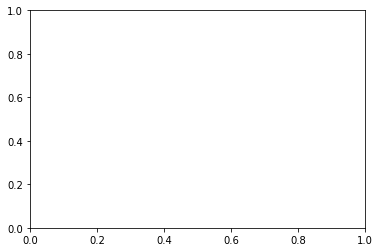

In [13]:
def plot_band_array(band_array,
                    refl_extent,
                    colorlimit,
                    ax=plt.gca(),
                    title='',
                    cbar ='on',
                    cmap_title='',
                    colormap='spectral'):
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90);

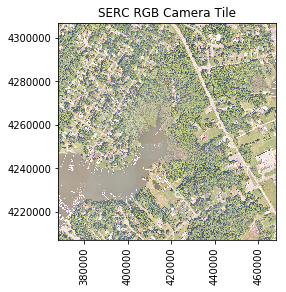

In [14]:
plot_band_array(SERC_RGBcam_array, SERC_RGBcam_metadata['extent'], (1,255), title='SERC RGB Camera Tile', cbar='off')

Text(0,0.5,'Frequency')

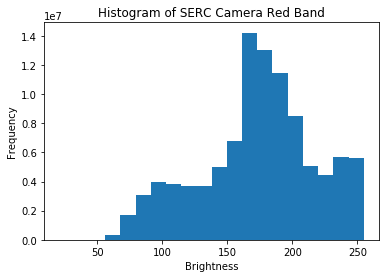

In [16]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,0]),20);
plt.title('Histogram of SERC Camera Red Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

## Challenge Exercises

### Histograms

Text(0,0.5,'Frequency')

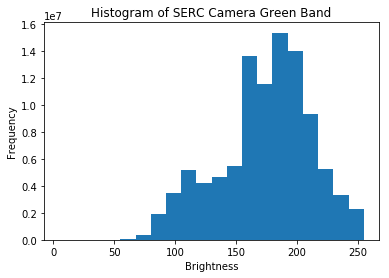

In [19]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,1]),20);
plt.title('Histogram of SERC Camera Green Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

Text(0,0.5,'Frequency')

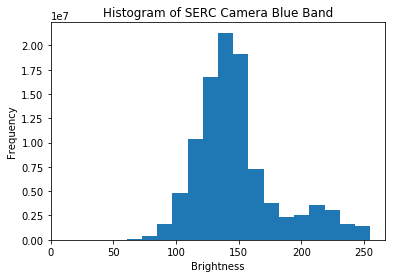

In [20]:
plt.hist(np.ravel(SERC_RGBcam_array[:,:,2]),20);
plt.title('Histogram of SERC Camera Blue Band')
plt.xlabel('Brightness'); plt.ylabel('Frequency')

### Band Minima and Maxima

In [21]:
Band1min = np.amin(SERC_RGBcam_array[:,:,0])
Band2min = np.amin(SERC_RGBcam_array[:,:,1])
Band3min = np.amin(SERC_RGBcam_array[:,:,2])

Band1max = np.amax(SERC_RGBcam_array[:,:,0])
Band2max = np.amax(SERC_RGBcam_array[:,:,1])
Band3max = np.amax(SERC_RGBcam_array[:,:,2])
                
print("Band 1 (Red): Reflectance Values Span " + str(Band1min) + " to " + str(Band1max))
print("Band 2 (Green): Reflectance Values Span " + str(Band2min) + " to " + str(Band2max))
print("Band 3 (Blue): Reflectance Values Span " + str(Band3min) + " to " + str(Band3max))

Band 1 (Red): Reflectance Values Span 21 to 255
Band 2 (Green): Reflectance Values Span 5 to 255
Band 3 (Blue): Reflectance Values Span 12 to 255


### Projection

In [22]:
print(SERC_RGBcam_metadata['projection'])

PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


* The Projection is in UTM zone 18N *

### Map Plot of Red Band

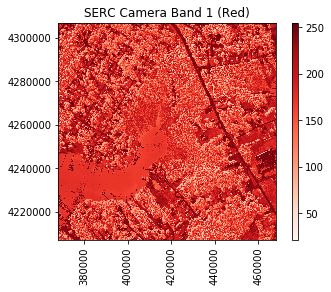

In [27]:
plot_band_array(SERC_RGBcam_array[:,:,0],
                SERC_RGBcam_metadata['extent'],
                (Band1min,Band1max),
                title='SERC Camera Band 1 (Red)',
                cbar='on',
                colormap='Reds')

### Map Plot of Green Band

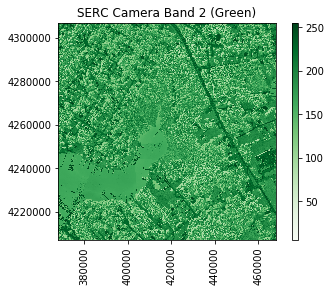

In [25]:
plot_band_array(SERC_RGBcam_array[:,:,1],
                SERC_RGBcam_metadata['extent'],
                (Band2min,Band2max),
                title='SERC Camera Band 2 (Green)',
                cbar='on',
                colormap='Greens')

### Map Plot of Blue Band

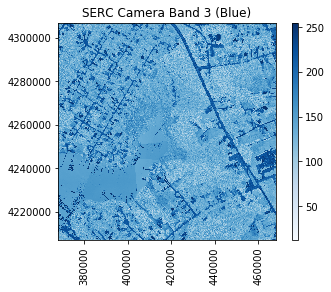

In [26]:
plot_band_array(SERC_RGBcam_array[:,:,2],
                SERC_RGBcam_metadata['extent'],
                (Band3min,Band3max),
                title='SERC Camera Band 3 (Blue)',
                cbar='on',
                colormap='Blues')